# Visual Robot Collision Identification

We are deploying a Kuka robot in a factory, and we want to implement a remote visual monitoring system. Part of this system includes automatic identification of collisions. We will train a machine learning model on image data to build this system. We've provided some code from previous assignments to facilitate this task.

**You should download this notebook and complete it on Colab or another platform that can access GPU hardware. For submission, please attach the notebook printout to your PDF submission on Gradescope, and also re-upload the completed notebook with outputs here.**

In [3]:
!pip install pybullet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 5.5 MB/s eta 0:00:00


In [4]:
import os
import time
import pybullet as p
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpl_img
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

In [5]:
# Set up the simulation
sim_id = p.connect(p.DIRECT)

In [6]:
# PyBullet has a lot of built-in data (e.g., robor models), so let's get access to it
import pybullet_data
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [7]:
# load up the robots!
p.resetSimulation()
plane_id=p.loadURDF('plane.urdf',
            physicsClientId=sim_id)
robot_id=p.loadURDF("kuka_iiwa/model.urdf",
            basePosition=[0,0,0],
            baseOrientation=p.getQuaternionFromEuler([0,0,0]),
            useFixedBase=True,
            physicsClientId=sim_id,
            globalScaling=1,
            flags=p.URDF_USE_IMPLICIT_CYLINDER)
cube_id=p.loadURDF('cube.urdf',
            basePosition=[0.5, 0, 0.5],
            physicsClientId=sim_id,
            globalScaling=0.3)
sphere_id=p.loadURDF('sphere2.urdf',
            basePosition=[0, 0.5, 0.5],
            physicsClientId=sim_id,
            globalScaling=0.3)
p.getNumBodies()

4

In [8]:
def is_collision():
    p.performCollisionDetection(physicsClientId=sim_id)
    all_contact_points = [cp for cp in p.getContactPoints(bodyA=robot_id) \
                          if cp[1] != plane_id and cp[2] != plane_id and cp[8] < 0]
    # cp[1] is first collision object, cp[2] is second collision object
    # cp[8] is collision distance, where NEGATIVE value indicates penetration (pos value is separation)
    return len(all_contact_points) > 0

In [9]:
JOINT_LIMITS = np.array([np.pi * 3/4, np.pi * 2/3, np.pi * 3/4, np.pi * 2/3, np.pi * 3/4, np.pi * 2/3, np.pi * 3/4])

# Part 1: Model Selection (4 pts)

We will be using a pre-trained ResNet-18 model, which is a type of convolutional neural network. Briefly answer the following:
* Why is a convolutional neural network a good choice for this task?
* Why is a pre-trained model a good choice for this task?


* A convolutional neural network are great for image processing and have different layers that work well with our 3-dimensional images, instead of vectorizing them. We need to scale well to full images, so this Conv Net is great.
* A Pretrained model allows us to use existing weights and just finetune them for our task. ResNet-18 has already been pretrained on a large diverse dataset so this model can already recognize a lot of different features, which we need for this visual monitoring system.

# Part 2: Data Collection (8 pts)

We will generate training data by collecting 1000 images of robots in various collision statuses. We can do so by repeating the following steps:
* Sample a random configuration within joint limits.
* Find its collision status using `is_collision()`.
* Generate and store the rgb image using `show_image()` (needs to be amended).

The images should be saved in a folder called ``robot_imgs``, with file name formats ``pose{sample_number}_{collision_status}.png``, where ``collision_status`` is 1 for collision, 0 for no collision. See below for proposed directory format.

```
robot_imgs/
  pose0_1.png
  pose1_1.png
  pose2_1.png
  pose3_0.png
  pose4_0.png
  pose5_1.png
  pose6_0.png
```



In [10]:
# run this if you need to regenerate the images
import shutil
if os.path.exists('robot_imgs'):
    shutil.rmtree('robot_imgs')
os.makedirs('robot_imgs', exist_ok=True)

In [11]:
def showImage(img_idx, collision_status, cameraPos=[2, 2, 2]):
    # Let's take some images, as a sanity check:
    viewMatrix = p.computeViewMatrix(
                cameraEyePosition=cameraPos,
                cameraTargetPosition=[0, 0, 0],
                cameraUpVector=[0, 0, 1])
    projectionMatrix = p.computeProjectionMatrixFOV(
                fov=60.0,
                aspect=1.0,
                nearVal=0.1,
                farVal=10)
    width, height, rgbImg, depthImg, segImg = p.getCameraImage(
                width=512,
                height=512,
                viewMatrix=viewMatrix,
                projectionMatrix=projectionMatrix)

    # TODO: Save the image in folder structure as shown above.
    # HINT: use matplotlib.image (already imported as mpl_img)

    dir= 'robot_imgs'
    filename=f'pose{img_idx}_{collision_status}.png'

    filepath= os.path.join(dir, filename)
    mpl_img.imsave(filepath, rgbImg)


In [12]:
# TODO: Sample and save 1000 images of robot configurations and their collision status
for i in tqdm(range(1000), desc="Saving Images"):
  q=np.random.uniform(-JOINT_LIMITS, JOINT_LIMITS)
  for j in range(len(q)):
    p.resetJointState(robot_id, j, q[j])
  if is_collision():
    showImage(i, 1)
  else:
    showImage(i, 0)

Saving Images: 100%|██████████| 1000/1000 [01:50<00:00,  9.03it/s]


# Part 3: Dataset Class (10 pts)

We will be using PyTorch to train a model. We need to have a ``Dataset`` subclass, which gives data to PyTorch in the form of tuples ``(image, label)``. We also want an option to split the images into train and test sets, which we can do by specifying `desired_indices` as the training images. Feel free to read this tutorial (from which much of the code in this assignment was adopted) for help: [PyTorch DataLoading](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Complete the main loop in the ``load_all_images()`` function in the ``RobotCollisionDataset`` class below by performing the following:

* Retrieve each image with index in `desired_indices`.
* Convert the image to a tensor and ensure that its dimensions are `(3,512,512)`. [`torch.from_numpy()`](https://pytorch.org/docs/stable/generated/torch.from_numpy.html) and [`torch.permute()`](https://pytorch.org/docs/stable/generated/torch.permute.html) may be useful here.
* Append the tensor to the `images` list and the corresponding collision status (1/0) to the `labels` list.

In [27]:
class RobotCollisionDataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self, root_dir, desired_indices):
        """
        Arguments:
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.desired_indices = desired_indices

        self.transform = transforms.Compose([
            transforms.Normalize((201, 212, 230), (42, 33, 23)),
            transforms.Resize((224, 224))
        ])

        self.images, self.labels = self.load_all_images()


    def load_all_images(self):
        """
        Creates:
        -> self.images: contains robot images from self.root_dir
        -> self.labels: self.labels[i] = 1 if self.images[i] depicts a collision, 0 otherwise
        """
        images = list()
        labels = list()
        assert os.path.exists(self.root_dir)

        for filename in tqdm(os.listdir(self.root_dir), desc='Loading images'):
            # TODO: Load all images from file directory

            comp= filename.split('_')
            #get number after pose
            sample_number= int(comp[0][4:])
            #get last number
            collision_status= int(comp[1][0])

            if sample_number in self.desired_indices:
              dir=self.root_dir
              filepath= os.path.join(dir, filename)
              image= self.load_image(filepath)
              img = image[:,:,:3]
              tensor_img= torch.from_numpy(img)
              if tensor_img.ndim == 3 and tensor_img.shape[2] == 3:
                tensor_img=tensor_img.permute(2,0,1)
                transform_img = self.transform(tensor_img) #transform before appending
                images.append(transform_img)
                labels.append(collision_status)

        assert len(labels) == len(images)
        return images, labels

    # Thanks https://stackoverflow.com/a/7769424
    def load_image(self, infilename) :
        img = Image.open(infilename)
        img.load()
        data = np.asarray(img, dtype="float32")
        return data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()
      # return self.transform(self.images[idx]), self.labels[idx]
      #we don't have to transform here anymore
      return self.images[idx], self.labels[idx]

# Part 4: Loading the Data and Model (6 pts)

Now we can create our dataset and store it in two `RobotCollisionDataset` objects. First define `train_dataset` containing 900 images, and `val_dataset` containing the remaining 100 images. This should only require a couple lines of code.

Next, we will load a pre-trained ResNet model. To use it for our collision detection task, we need to ensure that the model has the correct output layer dimensionality. Recall that the output layer for a neural network is the probability distribution over categories. Natively, ResNet has 1000 dimensions in the output layer because it was trained for a 1000-category classification task.

Load the `resnet18` model with default weights into a variable called `model` and change its dimensionality as necessary. This should only require a couple lines of code. This tutorial may be helpful: [Transfer Learning for Computer Vision](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [28]:
# TODO: Create train and validation datasets
train_dataset= RobotCollisionDataset(root_dir='/content/robot_imgs', desired_indices=list(range(900)))
val_dataset= RobotCollisionDataset(root_dir='/content/robot_imgs', desired_indices=list(range(900, 1000)))

Loading images: 100%|██████████| 1000/1000 [00:01<00:00, 909.16it/s]


In [83]:
# TODO: Load and adjust a pre-trained model

model = resnet18()
num_ftrs= model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Part 5: Training the Model (4 pts)

The last function we need to write is one that will train and validate the model. We have a partial implementation of `train_model()` below. Complete the loop portion that performs prediction and obtains a loss on an input. Additionally, if the current `phase` is `'train'`, you will need to perform an optimization step on the model (this second step would not be done if `phase` is `'val'`).

Note that this function essentially replicates the example shown in the [Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) tutorial. You are free to replicate any code from there to complete the implementation.

In [30]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25, device='cuda'):
    since = time.time()
    best_model_params_path = 'best_model_params.pt'
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    train_losses = list()
    train_accs = list()
    val_losses = list()
    val_accs = list()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # TODO: Obtain model prediction and loss on inputs
                # If in training phase, compute gradients and perform optimization step
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, train_accs, val_losses, val_accs

# Part 6: Putting Everything Together (8 pts)

Now we are ready to put everything together. The following code sets up the required components (model, criterion, optimizer, scheduler) and then runs the training function that you completed above. There are also some parameters, e.g. learning rate and number of epochs, that you can experiment with after verifying initial success.

**NOTE: Set your runtime hardware to ``T4 GPU`` only when you are ready to train the full model. Do not do so before that, or you will risk using up your GPU quota. It takes almost two hours to train on CPU, but only about five minutes on GPU.**

Run the provided code, and address the prompts below.

1. Use ``plot_losses()`` to plot the training and validation losses. Describe your observations and how they indicate that our learning task is successful (or failed).

2. Use ``visualize_model()`` to see some images along with their predictions. Do the predictions appear mostly correct? Do you see any failure cases?

3. Experiment with changing the learning rate and number of epochs. You can just try a lower and a higher value for each parameter separately. Comment on changes in model performance.

4. Experiment with loading a ResNet model that isn't pre-trained. Comment on changes in model performance.

1.   The learning task is successful, as we see the validation losses decreases as we go over more epochs. The validation losses increases slightly after some epochs, bu overall the losses decrease and stabilize, indicating the model learns how to classify images the best it can given the set of training data.
2.   Yes, the predictions appear mostly correct. There is one case of the six that is incorrect. In the fourth case, the model predicts that the robot has a  collision, when the robot is actually collision free.
3.   Original validation accuracy: 85%
  *   When decreasing the learning rate from 0.001 to 0.0005
      * Val acc decreases to 80%, which makes sense as the model is able to learn (update its weight with small step sizes) less each epoch, resulting in less validation, as it has less opportunity to converge given the number of epochs.
  *   When increasing the learning rate from 0.001 to 0.003
      * Val acc increases to 86%, which makes sense as the model can learn more (update its weight with large step sizes), allowing the model to have more opportunities to converge to a better validation.
  *   When increasing the number of epochs rate from 25 to 50
      * Val acc increases to 87%, which makes sense as the model has more passes through the dataset, allowing for more accurately change its weights to fit the dataset.
  *   When decreasing the number of epochs rate from 25 to 10
      * Val acc decreases to 83%, which makes sense as the model has less passes through the dataset and less opportunities to change its weights to fit the dataset.

4.   When using the pretrained 'ResNet18_Weights' resnet18 model, the validation accuracy increases to 90%. This makes sense, as there is an existing set of weights, allowing the model to get simply finetune these weights rather than having to discover the correct weights from scratch, therefore the model gets more accurate predictions with its passes/epochs.

In [84]:
learning_rate = 0.001
num_epochs = 25

data_loader_train = DataLoader(train_dataset,
                            batch_size=64, shuffle=True)
data_loader_val = DataLoader(val_dataset,
                            batch_size=64, shuffle=True)
dataloaders = {'train': data_loader_train,
               'val': data_loader_val}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [85]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


train Loss: 0.5478 Acc: 0.7600


100%|██████████| 2/2 [00:00<00:00, 18.54it/s]


val Loss: 0.5730 Acc: 0.7400

Epoch 1/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.65it/s]


train Loss: 0.4863 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 18.03it/s]


val Loss: 0.5429 Acc: 0.7400

Epoch 2/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.4426 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 18.73it/s]


val Loss: 0.4991 Acc: 0.7400

Epoch 3/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.62it/s]


train Loss: 0.4111 Acc: 0.7822


100%|██████████| 2/2 [00:00<00:00, 18.05it/s]


val Loss: 0.4674 Acc: 0.7500

Epoch 4/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.51it/s]


train Loss: 0.3874 Acc: 0.8267


100%|██████████| 2/2 [00:00<00:00, 17.00it/s]


val Loss: 0.4509 Acc: 0.7600

Epoch 5/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


train Loss: 0.3580 Acc: 0.8622


100%|██████████| 2/2 [00:00<00:00, 17.30it/s]


val Loss: 0.4502 Acc: 0.7600

Epoch 6/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


train Loss: 0.3147 Acc: 0.8756


100%|██████████| 2/2 [00:00<00:00, 17.58it/s]


val Loss: 0.3863 Acc: 0.8300

Epoch 7/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.45it/s]


train Loss: 0.2893 Acc: 0.8956


100%|██████████| 2/2 [00:00<00:00, 17.31it/s]


val Loss: 0.3790 Acc: 0.8300

Epoch 8/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


train Loss: 0.2776 Acc: 0.9011


100%|██████████| 2/2 [00:00<00:00, 18.05it/s]


val Loss: 0.3770 Acc: 0.8300

Epoch 9/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


train Loss: 0.2745 Acc: 0.8967


100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


val Loss: 0.3741 Acc: 0.8100

Epoch 10/24
----------


100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


train Loss: 0.2671 Acc: 0.9033


100%|██████████| 2/2 [00:00<00:00, 12.45it/s]


val Loss: 0.3723 Acc: 0.8300

Epoch 11/24
----------


100%|██████████| 15/15 [00:03<00:00,  4.91it/s]


train Loss: 0.2657 Acc: 0.9056


100%|██████████| 2/2 [00:00<00:00, 18.60it/s]


val Loss: 0.3642 Acc: 0.8500

Epoch 12/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


train Loss: 0.2625 Acc: 0.9033


100%|██████████| 2/2 [00:00<00:00, 17.74it/s]


val Loss: 0.3693 Acc: 0.8100

Epoch 13/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.42it/s]


train Loss: 0.2578 Acc: 0.9111


100%|██████████| 2/2 [00:00<00:00, 18.19it/s]


val Loss: 0.3614 Acc: 0.8400

Epoch 14/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


train Loss: 0.2553 Acc: 0.9089


100%|██████████| 2/2 [00:00<00:00, 16.76it/s]


val Loss: 0.3571 Acc: 0.8500

Epoch 15/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.45it/s]


train Loss: 0.2524 Acc: 0.9178


100%|██████████| 2/2 [00:00<00:00, 17.16it/s]


val Loss: 0.3563 Acc: 0.8500

Epoch 16/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.45it/s]


train Loss: 0.2529 Acc: 0.9133


100%|██████████| 2/2 [00:00<00:00, 16.68it/s]


val Loss: 0.3554 Acc: 0.8500

Epoch 17/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2506 Acc: 0.9178


100%|██████████| 2/2 [00:00<00:00, 18.48it/s]


val Loss: 0.3556 Acc: 0.8500

Epoch 18/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2513 Acc: 0.9111


100%|██████████| 2/2 [00:00<00:00, 18.60it/s]


val Loss: 0.3566 Acc: 0.8400

Epoch 19/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


train Loss: 0.2462 Acc: 0.9167


100%|██████████| 2/2 [00:00<00:00, 18.25it/s]


val Loss: 0.3559 Acc: 0.8400

Epoch 20/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2545 Acc: 0.9133


100%|██████████| 2/2 [00:00<00:00, 18.45it/s]


val Loss: 0.3559 Acc: 0.8400

Epoch 21/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


train Loss: 0.2525 Acc: 0.9122


100%|██████████| 2/2 [00:00<00:00, 18.41it/s]


val Loss: 0.3545 Acc: 0.8500

Epoch 22/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


train Loss: 0.2507 Acc: 0.9167


100%|██████████| 2/2 [00:00<00:00, 18.62it/s]


val Loss: 0.3554 Acc: 0.8400

Epoch 23/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2514 Acc: 0.9133


100%|██████████| 2/2 [00:00<00:00, 16.69it/s]


val Loss: 0.3542 Acc: 0.8500

Epoch 24/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


train Loss: 0.2500 Acc: 0.9111


100%|██████████| 2/2 [00:00<00:00, 16.40it/s]


val Loss: 0.3540 Acc: 0.8500

Training complete in 1m 13s
Best val Acc: 0.850000


In [87]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([201/255, 212/255, 230/255])
    std = np.array([42/255, 33/255, 23/255])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloaders, num_images=6, class_names={0:'free', 1:'collision'}):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}; actual: {class_names[labels[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

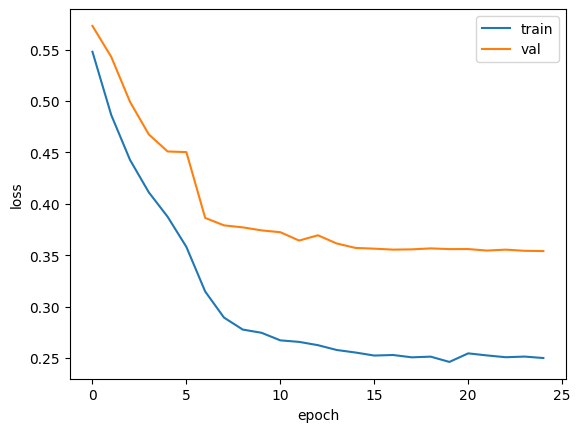

In [88]:
plot_losses(train_losses, val_losses)

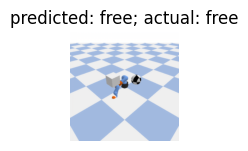

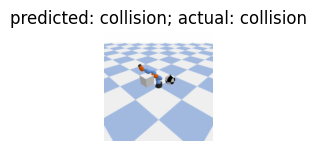

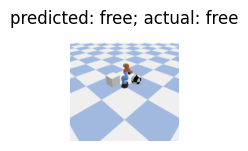

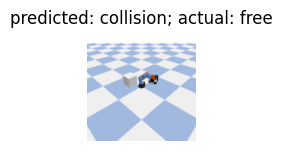

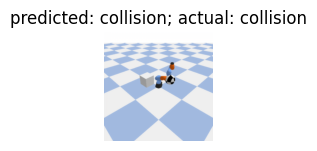

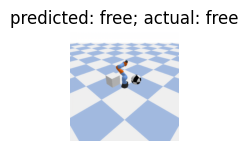

In [91]:
visualize_model(model, dataloaders)

In [92]:
model = resnet18()
num_ftrs= model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

learning_rate = 0.0005
num_epochs = 25

data_loader_train = DataLoader(train_dataset,
                            batch_size=64, shuffle=True)
data_loader_val = DataLoader(val_dataset,
                            batch_size=64, shuffle=True)
dataloaders = {'train': data_loader_train,
               'val': data_loader_val}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [93]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.5453 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 18.07it/s]


val Loss: 0.5693 Acc: 0.7400

Epoch 1/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


train Loss: 0.4916 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 17.21it/s]


val Loss: 0.5611 Acc: 0.7400

Epoch 2/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


train Loss: 0.4679 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 16.67it/s]


val Loss: 0.5231 Acc: 0.7400

Epoch 3/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.39it/s]


train Loss: 0.4478 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 18.73it/s]


val Loss: 0.4930 Acc: 0.7400

Epoch 4/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


train Loss: 0.4366 Acc: 0.7844


100%|██████████| 2/2 [00:00<00:00, 13.38it/s]


val Loss: 0.4879 Acc: 0.7400

Epoch 5/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


train Loss: 0.4317 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 17.90it/s]


val Loss: 0.4625 Acc: 0.7400

Epoch 6/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


train Loss: 0.4012 Acc: 0.8211


100%|██████████| 2/2 [00:00<00:00, 16.10it/s]


val Loss: 0.4642 Acc: 0.7400

Epoch 7/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.3823 Acc: 0.7822


100%|██████████| 2/2 [00:00<00:00, 18.33it/s]


val Loss: 0.4600 Acc: 0.7400

Epoch 8/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


train Loss: 0.3751 Acc: 0.7889


100%|██████████| 2/2 [00:00<00:00, 18.10it/s]


val Loss: 0.4483 Acc: 0.7500

Epoch 9/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.50it/s]


train Loss: 0.3746 Acc: 0.8111


100%|██████████| 2/2 [00:00<00:00, 18.23it/s]


val Loss: 0.4456 Acc: 0.7500

Epoch 10/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


train Loss: 0.3703 Acc: 0.8333


100%|██████████| 2/2 [00:00<00:00, 17.62it/s]


val Loss: 0.4429 Acc: 0.7700

Epoch 11/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


train Loss: 0.3682 Acc: 0.8344


100%|██████████| 2/2 [00:00<00:00, 18.55it/s]


val Loss: 0.4413 Acc: 0.7800

Epoch 12/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.48it/s]


train Loss: 0.3676 Acc: 0.8367


100%|██████████| 2/2 [00:00<00:00, 17.53it/s]


val Loss: 0.4401 Acc: 0.7700

Epoch 13/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.44it/s]


train Loss: 0.3634 Acc: 0.8411


100%|██████████| 2/2 [00:00<00:00, 17.71it/s]


val Loss: 0.4385 Acc: 0.7800

Epoch 14/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


train Loss: 0.3643 Acc: 0.8344


100%|██████████| 2/2 [00:00<00:00, 16.95it/s]


val Loss: 0.4376 Acc: 0.7800

Epoch 15/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.50it/s]


train Loss: 0.3633 Acc: 0.8444


100%|██████████| 2/2 [00:00<00:00, 18.23it/s]


val Loss: 0.4381 Acc: 0.7800

Epoch 16/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.3661 Acc: 0.8489


100%|██████████| 2/2 [00:00<00:00, 18.08it/s]


val Loss: 0.4391 Acc: 0.7700

Epoch 17/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


train Loss: 0.3633 Acc: 0.8444


100%|██████████| 2/2 [00:00<00:00, 17.90it/s]


val Loss: 0.4378 Acc: 0.7800

Epoch 18/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.3623 Acc: 0.8422


100%|██████████| 2/2 [00:00<00:00, 18.49it/s]


val Loss: 0.4376 Acc: 0.7800

Epoch 19/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.48it/s]


train Loss: 0.3611 Acc: 0.8500


100%|██████████| 2/2 [00:00<00:00, 18.33it/s]


val Loss: 0.4371 Acc: 0.8000

Epoch 20/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.3658 Acc: 0.8422


100%|██████████| 2/2 [00:00<00:00, 18.32it/s]


val Loss: 0.4368 Acc: 0.8000

Epoch 21/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


train Loss: 0.3630 Acc: 0.8444


100%|██████████| 2/2 [00:00<00:00, 18.22it/s]


val Loss: 0.4373 Acc: 0.8000

Epoch 22/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


train Loss: 0.3613 Acc: 0.8478


100%|██████████| 2/2 [00:00<00:00, 18.47it/s]


val Loss: 0.4385 Acc: 0.7700

Epoch 23/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.3610 Acc: 0.8422


100%|██████████| 2/2 [00:00<00:00, 16.61it/s]


val Loss: 0.4377 Acc: 0.7800

Epoch 24/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.3625 Acc: 0.8433


100%|██████████| 2/2 [00:00<00:00, 18.10it/s]

val Loss: 0.4374 Acc: 0.7800

Training complete in 1m 13s
Best val Acc: 0.800000


In [94]:
model = resnet18()
num_ftrs= model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
learning_rate = 0.003
num_epochs = 25

data_loader_train = DataLoader(train_dataset,
                            batch_size=64, shuffle=True)
data_loader_val = DataLoader(val_dataset,
                            batch_size=64, shuffle=True)
dataloaders = {'train': data_loader_train,
               'val': data_loader_val}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [95]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


train Loss: 0.5967 Acc: 0.7244


100%|██████████| 2/2 [00:00<00:00, 18.52it/s]


val Loss: 0.5577 Acc: 0.7400

Epoch 1/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


train Loss: 0.4892 Acc: 0.7933


100%|██████████| 2/2 [00:00<00:00, 18.27it/s]


val Loss: 0.5613 Acc: 0.7400

Epoch 2/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.4127 Acc: 0.8022


100%|██████████| 2/2 [00:00<00:00, 18.28it/s]


val Loss: 0.5131 Acc: 0.7400

Epoch 3/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


train Loss: 0.3334 Acc: 0.8678


100%|██████████| 2/2 [00:00<00:00, 18.38it/s]


val Loss: 0.4301 Acc: 0.7800

Epoch 4/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


train Loss: 0.2969 Acc: 0.8733


100%|██████████| 2/2 [00:00<00:00, 18.40it/s]


val Loss: 0.3618 Acc: 0.8400

Epoch 5/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.48it/s]


train Loss: 0.2689 Acc: 0.8889


100%|██████████| 2/2 [00:00<00:00, 18.49it/s]


val Loss: 0.3389 Acc: 0.8600

Epoch 6/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.47it/s]


train Loss: 0.1989 Acc: 0.9189


100%|██████████| 2/2 [00:00<00:00, 13.48it/s]


val Loss: 0.3212 Acc: 0.8500

Epoch 7/24
----------


100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


train Loss: 0.1624 Acc: 0.9400


100%|██████████| 2/2 [00:00<00:00, 18.37it/s]


val Loss: 0.3288 Acc: 0.8400

Epoch 8/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.1314 Acc: 0.9489


100%|██████████| 2/2 [00:00<00:00, 18.20it/s]


val Loss: 0.3359 Acc: 0.8400

Epoch 9/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.1236 Acc: 0.9589


100%|██████████| 2/2 [00:00<00:00, 18.07it/s]


val Loss: 0.3265 Acc: 0.8400

Epoch 10/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


train Loss: 0.1098 Acc: 0.9633


100%|██████████| 2/2 [00:00<00:00, 18.65it/s]


val Loss: 0.3394 Acc: 0.8400

Epoch 11/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


train Loss: 0.1152 Acc: 0.9633


100%|██████████| 2/2 [00:00<00:00, 17.21it/s]


val Loss: 0.3419 Acc: 0.8300

Epoch 12/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


train Loss: 0.0985 Acc: 0.9744


100%|██████████| 2/2 [00:00<00:00, 17.88it/s]


val Loss: 0.3563 Acc: 0.8500

Epoch 13/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


train Loss: 0.0916 Acc: 0.9756


100%|██████████| 2/2 [00:00<00:00, 18.41it/s]


val Loss: 0.3481 Acc: 0.8400

Epoch 14/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.0831 Acc: 0.9800


100%|██████████| 2/2 [00:00<00:00, 18.74it/s]


val Loss: 0.3448 Acc: 0.8500

Epoch 15/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


train Loss: 0.0822 Acc: 0.9822


100%|██████████| 2/2 [00:00<00:00, 17.79it/s]


val Loss: 0.3481 Acc: 0.8400

Epoch 16/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


train Loss: 0.0795 Acc: 0.9822


100%|██████████| 2/2 [00:00<00:00, 18.24it/s]


val Loss: 0.3491 Acc: 0.8400

Epoch 17/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


train Loss: 0.0829 Acc: 0.9822


100%|██████████| 2/2 [00:00<00:00, 18.06it/s]


val Loss: 0.3436 Acc: 0.8500

Epoch 18/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


train Loss: 0.0814 Acc: 0.9844


100%|██████████| 2/2 [00:00<00:00, 18.28it/s]


val Loss: 0.3432 Acc: 0.8500

Epoch 19/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


train Loss: 0.0812 Acc: 0.9856


100%|██████████| 2/2 [00:00<00:00, 17.40it/s]


val Loss: 0.3458 Acc: 0.8400

Epoch 20/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.47it/s]


train Loss: 0.0822 Acc: 0.9789


100%|██████████| 2/2 [00:00<00:00, 18.16it/s]


val Loss: 0.3411 Acc: 0.8500

Epoch 21/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


train Loss: 0.0800 Acc: 0.9822


100%|██████████| 2/2 [00:00<00:00, 18.31it/s]


val Loss: 0.3479 Acc: 0.8400

Epoch 22/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.0751 Acc: 0.9856


100%|██████████| 2/2 [00:00<00:00, 18.32it/s]


val Loss: 0.3512 Acc: 0.8500

Epoch 23/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


train Loss: 0.0862 Acc: 0.9800


100%|██████████| 2/2 [00:00<00:00, 18.04it/s]


val Loss: 0.3424 Acc: 0.8500

Epoch 24/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


train Loss: 0.0767 Acc: 0.9844


100%|██████████| 2/2 [00:00<00:00, 17.96it/s]


val Loss: 0.3526 Acc: 0.8500

Training complete in 1m 12s
Best val Acc: 0.860000


In [96]:
model = resnet18()
num_ftrs= model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
learning_rate = 0.001
num_epochs = 50

data_loader_train = DataLoader(train_dataset,
                            batch_size=64, shuffle=True)
data_loader_val = DataLoader(val_dataset,
                            batch_size=64, shuffle=True)
dataloaders = {'train': data_loader_train,
               'val': data_loader_val}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [97]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


train Loss: 0.5239 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 18.01it/s]


val Loss: 0.6086 Acc: 0.7400

Epoch 1/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.4801 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 18.62it/s]


val Loss: 0.5450 Acc: 0.7400

Epoch 2/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.4417 Acc: 0.7800


100%|██████████| 2/2 [00:00<00:00, 18.57it/s]


val Loss: 0.4966 Acc: 0.7400

Epoch 3/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


train Loss: 0.4181 Acc: 0.7967


100%|██████████| 2/2 [00:00<00:00, 14.38it/s]


val Loss: 0.4639 Acc: 0.7500

Epoch 4/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


train Loss: 0.3804 Acc: 0.8233


100%|██████████| 2/2 [00:00<00:00, 18.16it/s]


val Loss: 0.4391 Acc: 0.7900

Epoch 5/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.3588 Acc: 0.8689


100%|██████████| 2/2 [00:00<00:00, 18.28it/s]


val Loss: 0.4406 Acc: 0.7600

Epoch 6/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


train Loss: 0.3198 Acc: 0.8633


100%|██████████| 2/2 [00:00<00:00, 18.21it/s]


val Loss: 0.3963 Acc: 0.8500

Epoch 7/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2957 Acc: 0.9089


100%|██████████| 2/2 [00:00<00:00, 17.28it/s]


val Loss: 0.3945 Acc: 0.8600

Epoch 8/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.2893 Acc: 0.9022


100%|██████████| 2/2 [00:00<00:00, 18.29it/s]


val Loss: 0.3909 Acc: 0.8700

Epoch 9/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


train Loss: 0.2826 Acc: 0.9011


100%|██████████| 2/2 [00:00<00:00, 18.08it/s]


val Loss: 0.3874 Acc: 0.8700

Epoch 10/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


train Loss: 0.2830 Acc: 0.8944


100%|██████████| 2/2 [00:00<00:00, 18.32it/s]


val Loss: 0.3847 Acc: 0.8600

Epoch 11/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2764 Acc: 0.9078


100%|██████████| 2/2 [00:00<00:00, 17.96it/s]


val Loss: 0.3881 Acc: 0.8600

Epoch 12/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


train Loss: 0.2733 Acc: 0.9078


100%|██████████| 2/2 [00:00<00:00, 18.28it/s]


val Loss: 0.3816 Acc: 0.8600

Epoch 13/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2717 Acc: 0.9111


100%|██████████| 2/2 [00:00<00:00, 18.29it/s]


val Loss: 0.3828 Acc: 0.8600

Epoch 14/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.2659 Acc: 0.9122


100%|██████████| 2/2 [00:00<00:00, 18.26it/s]


val Loss: 0.3796 Acc: 0.8700

Epoch 15/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2656 Acc: 0.9178


100%|██████████| 2/2 [00:00<00:00, 18.39it/s]


val Loss: 0.3809 Acc: 0.8600

Epoch 16/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.2664 Acc: 0.9144


100%|██████████| 2/2 [00:00<00:00, 17.57it/s]


val Loss: 0.3801 Acc: 0.8600

Epoch 17/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


train Loss: 0.2647 Acc: 0.9144


100%|██████████| 2/2 [00:00<00:00, 18.21it/s]


val Loss: 0.3802 Acc: 0.8600

Epoch 18/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


train Loss: 0.2664 Acc: 0.9133


100%|██████████| 2/2 [00:00<00:00, 18.33it/s]


val Loss: 0.3814 Acc: 0.8600

Epoch 19/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


train Loss: 0.2695 Acc: 0.9144


100%|██████████| 2/2 [00:00<00:00, 18.25it/s]


val Loss: 0.3791 Acc: 0.8600

Epoch 20/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


train Loss: 0.2659 Acc: 0.9167


100%|██████████| 2/2 [00:00<00:00, 17.17it/s]


val Loss: 0.3781 Acc: 0.8700

Epoch 21/49
----------


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


train Loss: 0.2693 Acc: 0.9122


100%|██████████| 2/2 [00:00<00:00, 14.93it/s]


val Loss: 0.3775 Acc: 0.8600

Epoch 22/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


train Loss: 0.2674 Acc: 0.9100


100%|██████████| 2/2 [00:00<00:00, 17.98it/s]


val Loss: 0.3771 Acc: 0.8500

Epoch 23/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.50it/s]


train Loss: 0.2668 Acc: 0.9133


100%|██████████| 2/2 [00:00<00:00, 18.01it/s]


val Loss: 0.3771 Acc: 0.8400

Epoch 24/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.50it/s]


train Loss: 0.2667 Acc: 0.9200


100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


val Loss: 0.3794 Acc: 0.8600

Epoch 25/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


train Loss: 0.2633 Acc: 0.9178


100%|██████████| 2/2 [00:00<00:00, 12.44it/s]


val Loss: 0.3783 Acc: 0.8700

Epoch 26/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


train Loss: 0.2664 Acc: 0.9178


100%|██████████| 2/2 [00:00<00:00, 16.02it/s]


val Loss: 0.3769 Acc: 0.8600

Epoch 27/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


train Loss: 0.2659 Acc: 0.9167


100%|██████████| 2/2 [00:00<00:00, 17.57it/s]


val Loss: 0.3799 Acc: 0.8600

Epoch 28/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


train Loss: 0.2650 Acc: 0.9122


100%|██████████| 2/2 [00:00<00:00, 18.19it/s]


val Loss: 0.3776 Acc: 0.8600

Epoch 29/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


train Loss: 0.2664 Acc: 0.9144


100%|██████████| 2/2 [00:00<00:00, 14.87it/s]


val Loss: 0.3774 Acc: 0.8600

Epoch 30/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


train Loss: 0.2727 Acc: 0.9144


100%|██████████| 2/2 [00:00<00:00, 18.29it/s]


val Loss: 0.3835 Acc: 0.8600

Epoch 31/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2647 Acc: 0.9189


100%|██████████| 2/2 [00:00<00:00, 18.03it/s]


val Loss: 0.3776 Acc: 0.8700

Epoch 32/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


train Loss: 0.2622 Acc: 0.9167


100%|██████████| 2/2 [00:00<00:00, 18.34it/s]


val Loss: 0.3792 Acc: 0.8600

Epoch 33/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


train Loss: 0.2670 Acc: 0.9100


100%|██████████| 2/2 [00:00<00:00, 18.43it/s]


val Loss: 0.3785 Acc: 0.8600

Epoch 34/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


train Loss: 0.2662 Acc: 0.9111


100%|██████████| 2/2 [00:00<00:00, 18.26it/s]


val Loss: 0.3787 Acc: 0.8600

Epoch 35/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2657 Acc: 0.9189


100%|██████████| 2/2 [00:00<00:00, 18.10it/s]


val Loss: 0.3773 Acc: 0.8600

Epoch 36/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.2678 Acc: 0.9122


100%|██████████| 2/2 [00:00<00:00, 18.65it/s]


val Loss: 0.3777 Acc: 0.8700

Epoch 37/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.2676 Acc: 0.9200


100%|██████████| 2/2 [00:00<00:00, 18.89it/s]


val Loss: 0.3785 Acc: 0.8600

Epoch 38/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


train Loss: 0.2670 Acc: 0.9156


100%|██████████| 2/2 [00:00<00:00, 16.63it/s]


val Loss: 0.3834 Acc: 0.8600

Epoch 39/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.2660 Acc: 0.9189


100%|██████████| 2/2 [00:00<00:00, 18.57it/s]


val Loss: 0.3781 Acc: 0.8700

Epoch 40/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.2664 Acc: 0.9144


100%|██████████| 2/2 [00:00<00:00, 17.99it/s]


val Loss: 0.3787 Acc: 0.8600

Epoch 41/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


train Loss: 0.2639 Acc: 0.9211


100%|██████████| 2/2 [00:00<00:00, 18.02it/s]


val Loss: 0.3797 Acc: 0.8600

Epoch 42/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2675 Acc: 0.9156


100%|██████████| 2/2 [00:00<00:00, 17.46it/s]


val Loss: 0.3801 Acc: 0.8600

Epoch 43/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


train Loss: 0.2647 Acc: 0.9167


100%|██████████| 2/2 [00:00<00:00, 18.25it/s]


val Loss: 0.3771 Acc: 0.8600

Epoch 44/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.2665 Acc: 0.9189


100%|██████████| 2/2 [00:00<00:00, 17.93it/s]


val Loss: 0.3767 Acc: 0.8500

Epoch 45/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2642 Acc: 0.9156


100%|██████████| 2/2 [00:00<00:00, 18.62it/s]


val Loss: 0.3771 Acc: 0.8600

Epoch 46/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2667 Acc: 0.9133


100%|██████████| 2/2 [00:00<00:00, 18.55it/s]


val Loss: 0.3771 Acc: 0.8600

Epoch 47/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


train Loss: 0.2641 Acc: 0.9133


100%|██████████| 2/2 [00:00<00:00, 16.97it/s]


val Loss: 0.3802 Acc: 0.8600

Epoch 48/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


train Loss: 0.2658 Acc: 0.9156


100%|██████████| 2/2 [00:00<00:00, 17.24it/s]


val Loss: 0.3778 Acc: 0.8700

Epoch 49/49
----------


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


train Loss: 0.2651 Acc: 0.9144


100%|██████████| 2/2 [00:00<00:00, 18.44it/s]

val Loss: 0.3771 Acc: 0.8400

Training complete in 2m 25s
Best val Acc: 0.870000


In [98]:
model = resnet18()
num_ftrs= model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
learning_rate = 0.001
num_epochs = 10

data_loader_train = DataLoader(train_dataset,
                            batch_size=64, shuffle=True)
data_loader_val = DataLoader(val_dataset,
                            batch_size=64, shuffle=True)
dataloaders = {'train': data_loader_train,
               'val': data_loader_val}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [99]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


train Loss: 0.5142 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 18.70it/s]


val Loss: 0.5978 Acc: 0.7400

Epoch 1/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


train Loss: 0.4769 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 17.40it/s]


val Loss: 0.5546 Acc: 0.7400

Epoch 2/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.4404 Acc: 0.7789


100%|██████████| 2/2 [00:00<00:00, 18.63it/s]


val Loss: 0.4978 Acc: 0.7400

Epoch 3/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.48it/s]


train Loss: 0.4231 Acc: 0.7967


100%|██████████| 2/2 [00:00<00:00, 17.31it/s]


val Loss: 0.4874 Acc: 0.7400

Epoch 4/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


train Loss: 0.3956 Acc: 0.8133


100%|██████████| 2/2 [00:00<00:00, 17.77it/s]


val Loss: 0.4586 Acc: 0.7500

Epoch 5/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


train Loss: 0.3644 Acc: 0.8633


100%|██████████| 2/2 [00:00<00:00, 12.02it/s]


val Loss: 0.4824 Acc: 0.7400

Epoch 6/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


train Loss: 0.3466 Acc: 0.8400


100%|██████████| 2/2 [00:00<00:00, 18.55it/s]


val Loss: 0.3929 Acc: 0.7900

Epoch 7/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.3114 Acc: 0.9033


100%|██████████| 2/2 [00:00<00:00, 18.39it/s]


val Loss: 0.3849 Acc: 0.8200

Epoch 8/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


train Loss: 0.2974 Acc: 0.8944


100%|██████████| 2/2 [00:00<00:00, 18.53it/s]


val Loss: 0.3897 Acc: 0.8300

Epoch 9/9
----------


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


train Loss: 0.2896 Acc: 0.8967


100%|██████████| 2/2 [00:00<00:00, 18.41it/s]


val Loss: 0.3806 Acc: 0.8300

Training complete in 0m 30s
Best val Acc: 0.830000


In [79]:
model = resnet18(weights='ResNet18_Weights')
num_ftrs= model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [80]:
learning_rate = 0.001
num_epochs = 25

data_loader_train = DataLoader(train_dataset,
                            batch_size=64, shuffle=True)
data_loader_val = DataLoader(val_dataset,
                            batch_size=64, shuffle=True)
dataloaders = {'train': data_loader_train,
               'val': data_loader_val}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [81]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.44it/s]


train Loss: 0.5199 Acc: 0.7489


100%|██████████| 2/2 [00:00<00:00, 16.71it/s]


val Loss: 0.4463 Acc: 0.7700

Epoch 1/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.64it/s]


train Loss: 0.3348 Acc: 0.8500


100%|██████████| 2/2 [00:00<00:00, 18.44it/s]


val Loss: 0.3786 Acc: 0.8200

Epoch 2/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.67it/s]


train Loss: 0.2503 Acc: 0.8956


100%|██████████| 2/2 [00:00<00:00, 18.80it/s]


val Loss: 0.2879 Acc: 0.8600

Epoch 3/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.63it/s]


train Loss: 0.2057 Acc: 0.9211


100%|██████████| 2/2 [00:00<00:00, 18.29it/s]


val Loss: 0.3430 Acc: 0.8600

Epoch 4/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


train Loss: 0.1514 Acc: 0.9444


100%|██████████| 2/2 [00:00<00:00, 16.99it/s]


val Loss: 0.3809 Acc: 0.8800

Epoch 5/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


train Loss: 0.1327 Acc: 0.9511


100%|██████████| 2/2 [00:00<00:00, 18.67it/s]


val Loss: 0.3112 Acc: 0.9000

Epoch 6/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


train Loss: 0.1861 Acc: 0.9333


100%|██████████| 2/2 [00:00<00:00, 18.56it/s]


val Loss: 0.5316 Acc: 0.7700

Epoch 7/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


train Loss: 0.1365 Acc: 0.9456


100%|██████████| 2/2 [00:00<00:00, 18.49it/s]


val Loss: 0.3492 Acc: 0.8700

Epoch 8/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.52it/s]


train Loss: 0.1064 Acc: 0.9656


100%|██████████| 2/2 [00:00<00:00, 16.06it/s]


val Loss: 0.3368 Acc: 0.8800

Epoch 9/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.05it/s]


train Loss: 0.0909 Acc: 0.9800


100%|██████████| 2/2 [00:00<00:00, 18.33it/s]


val Loss: 0.3294 Acc: 0.8900

Epoch 10/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


train Loss: 0.0895 Acc: 0.9744


100%|██████████| 2/2 [00:00<00:00, 18.71it/s]


val Loss: 0.3272 Acc: 0.8900

Epoch 11/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


train Loss: 0.0821 Acc: 0.9822


100%|██████████| 2/2 [00:00<00:00, 18.14it/s]


val Loss: 0.3176 Acc: 0.9000

Epoch 12/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.45it/s]


train Loss: 0.0739 Acc: 0.9856


100%|██████████| 2/2 [00:00<00:00, 18.06it/s]


val Loss: 0.3185 Acc: 0.9000

Epoch 13/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.05it/s]


train Loss: 0.0697 Acc: 0.9844


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


val Loss: 0.3240 Acc: 0.9000

Epoch 14/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


train Loss: 0.0699 Acc: 0.9878


100%|██████████| 2/2 [00:00<00:00, 18.43it/s]


val Loss: 0.3193 Acc: 0.9000

Epoch 15/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.09it/s]


train Loss: 0.0627 Acc: 0.9900


100%|██████████| 2/2 [00:00<00:00, 12.55it/s]


val Loss: 0.3287 Acc: 0.9000

Epoch 16/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


train Loss: 0.0628 Acc: 0.9856


100%|██████████| 2/2 [00:00<00:00, 18.08it/s]


val Loss: 0.3256 Acc: 0.9000

Epoch 17/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


train Loss: 0.0642 Acc: 0.9844


100%|██████████| 2/2 [00:00<00:00, 18.27it/s]


val Loss: 0.3233 Acc: 0.8900

Epoch 18/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


train Loss: 0.0629 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00, 18.43it/s]


val Loss: 0.3289 Acc: 0.9000

Epoch 19/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


train Loss: 0.0680 Acc: 0.9844


100%|██████████| 2/2 [00:00<00:00, 18.43it/s]


val Loss: 0.3267 Acc: 0.9000

Epoch 20/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


train Loss: 0.0686 Acc: 0.9833


100%|██████████| 2/2 [00:00<00:00, 17.98it/s]


val Loss: 0.3357 Acc: 0.9000

Epoch 21/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


train Loss: 0.0695 Acc: 0.9800


100%|██████████| 2/2 [00:00<00:00, 17.86it/s]


val Loss: 0.3298 Acc: 0.9000

Epoch 22/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


train Loss: 0.0643 Acc: 0.9878


100%|██████████| 2/2 [00:00<00:00, 18.46it/s]


val Loss: 0.3323 Acc: 0.9000

Epoch 23/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.63it/s]


train Loss: 0.0638 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00, 18.47it/s]


val Loss: 0.3284 Acc: 0.9000

Epoch 24/24
----------


100%|██████████| 15/15 [00:02<00:00,  5.62it/s]


train Loss: 0.0701 Acc: 0.9833


100%|██████████| 2/2 [00:00<00:00, 18.62it/s]

val Loss: 0.3313 Acc: 0.9000

Training complete in 1m 13s
Best val Acc: 0.900000
